In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as mpl
import arctic
from functions import generate_volumebars, get_tick_data, generate_dollarbars
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.stats.stattools import jarque_bera
from chap5_functions import *
from tqdm.notebook import tqdm
pd.set_option('float_format', '{:f}'.format)

In [3]:
start_date = datetime(2020,7,1)
end_date = datetime(2020,7,15)

df = get_tick_data('binance_futures', 'BTCUSDT', start_date, end_date)

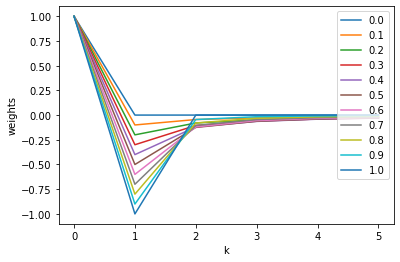

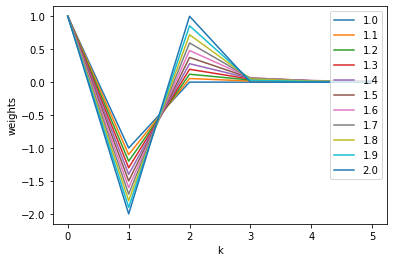

In [8]:
plotWeights(dRange=[0,1],nPlots=11,size=6)
plotWeights(dRange=[1,2],nPlots=11,size=6)

In [18]:
getWeights(-1,15)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

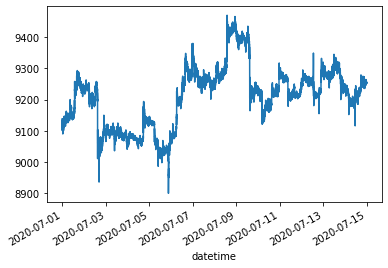

In [52]:
bars = generate_volumebars(df[['dt', 'price', 'quantity']].values, 1)
bars.close.plot()

In [53]:
bars.shape


(886981, 6)

In [54]:
df.shape

(3677503, 7)

## Expanding Window

In [8]:
w = getWeights(1, bars.shape[0])[::-1]
#2) Determine initial calcs to be skipped based on weight-loss threshold 
w_ = np.cumsum(abs(w))
w_ /= w_[-1]
w_[w_ > 0].shape[0]
# w_ > 0.01

2

/Users/sebastian/GoldenEye/env/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app


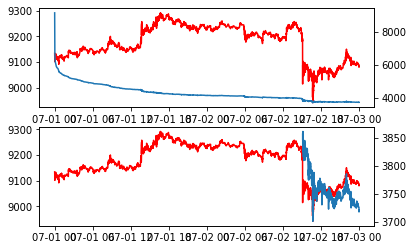

In [9]:
# %debug
fig, (ax, ax0) = mpl.subplots(2,1)
a = fracDiff(bars[['close']], 0.1,thres=1)
ax.plot(bars.close, color='r')
ax1=ax.twinx()
ax1.plot(a)

b = fracDiff(bars[['close']], 0.1,thres=0.01)
ax0.plot(bars.close, color='r')
ax2=ax0.twinx()
ax2.plot(b)

## Fixed-Width Window Fracdiff

/Users/sebastian/GoldenEye/env/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


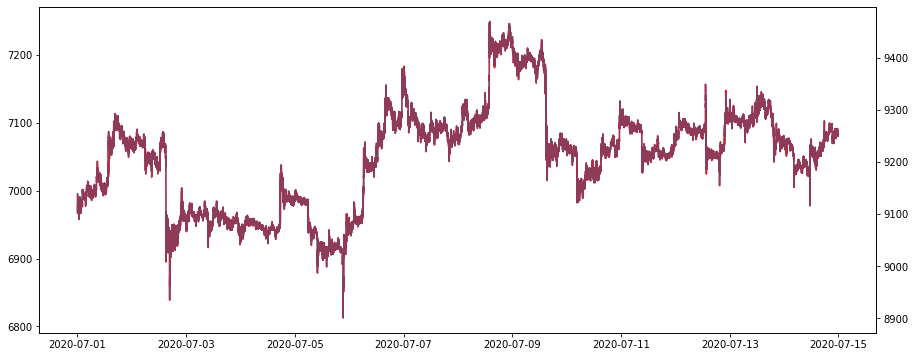

In [58]:
# %debug
fig, (ax) = mpl.subplots(1, figsize=(15,6))
ax0=ax.twinx()
a = fracDiff_FFD((bars[['close']]), d=0.1, thres=0.01)
ax0.plot(bars.close, alpha=0.5)
ax.plot(a, color='r')



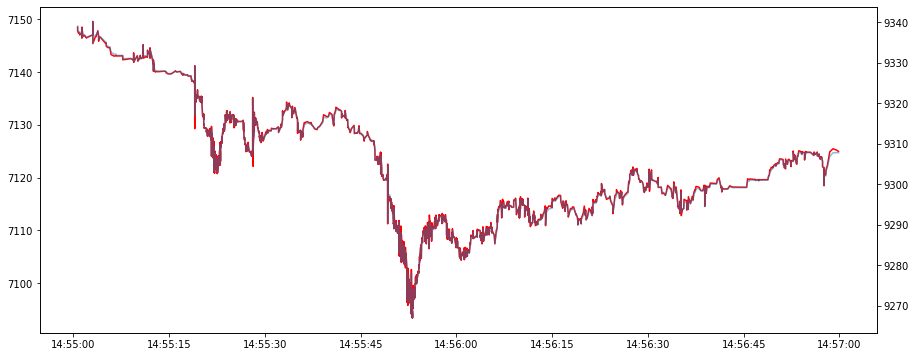

In [79]:
fig, (ax) = mpl.subplots(1, figsize=(15,6))
ax0=ax.twinx()
# a = fracDiff_FFD((bars[['close']]), d=0.1, thres=0.01)
ax0.plot(bars.close[(bars.index>'2020-07-09 14:55:00') & (bars.index < '2020-07-09 14:57:00')], alpha=0.5)
ax.plot(a[(a.index>'2020-07-09 14:55:00') & (a.index < '2020-07-09 14:57:00')], color='r')

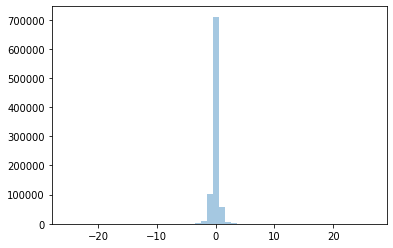

In [82]:
import seaborn as sns
sns.distplot(a.diff(), kde=False)

## FINDING THE MINIMUM D VALUE THAT PASSES THE ADF TEST

/Users/sebastian/GoldenEye/env/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


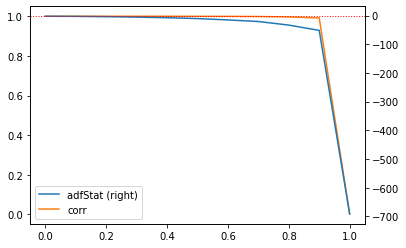

In [55]:
out = plotMinFFD()

In [57]:
out[out.adfStat < out['95% conf']].head(10)

,adfStat,pVal,lags,nObs,95% conf,corr
0.100000,-2.874079,0.048446,1.000000,886972.000000,-2.861543,0.999998
0.200000,-3.872091,0.002250,1.000000,886969.000000,-2.861543,0.999984
0.300000,-5.404707,0.000003,1.000000,886968.000000,-2.861543,0.999942
0.400000,-7.442067,0.000000,1.000000,886969.000000,-2.861543,0.999858
0.500000,-10.483939,0.000000,1.000000,886970.000000,-2.861543,0.999677
0.600000,-15.205504,0.000000,1.000000,886971.000000,-2.861543,0.999271
0.700000,-20.774405,0.000000,1.000000,886973.000000,-2.861543,0.998627
0.800000,-33.207572,0.000000,1.000000,886974.000000,-2.861543,0.996401
0.900000,-51.653860,0.000000,1.000000,886976.000000,-2.861543,0.991295
1.000000,-691.200934,0.000000,1.000000,886978.000000,-2.861543,0.002634


## EXERCISES
1. Generate a time series from an IID Gaussian random process. This is a memory- less, stationary series:
- (a) Compute the ADF statistic on this series. What is the p-value?
- (b) Compute the cumulative sum of the observations. This is a non-stationary
series without memory.
  - (i) What is the order of integration of this cumulative series?
  - (ii) Compute the ADF statistic on this series. What is the p-value?
- (c) Differentiate the series twice. What is the p-value of this over-differentiated
series?

In [12]:
grp =  np.random.normal(loc=0.0, scale=1.0, size=1000).reshape((1000,1))
# print(np.mean(grp), np.std(grp))
adf, pval, lag, nobs, cv = adfuller(grp, maxlag=1, regression='c', autolag=None)
print('(a) P-value: {}'.format(pval))
grp2 = np.cumsum(grp)

adf = adfuller(fracDiff(pd.DataFrame(grp2), 1, thres=1), maxlag=1, regression='c', autolag=None)
print('(b) i P-value: {}'.format(adf[1]))

adf = adfuller(grp2, maxlag=1, regression='c', autolag=None)
print('(b) ii P-value: {}'.format(adf[1]))
grp2 = fracDiff(pd.DataFrame(grp2), 2, thres=1)
adf = adfuller(grp2, maxlag=1, regression='c', autolag=None)
print('(c) P-value: {}'.format(adf[1]))


(a) P-value: 0.0
(b) i P-value: 0.0
(b) ii P-value: 0.6947367584645571
(c) P-value: 0.0


### 2. Generate a time series that follows a sinusoidal function. This is a stationary series with memory.

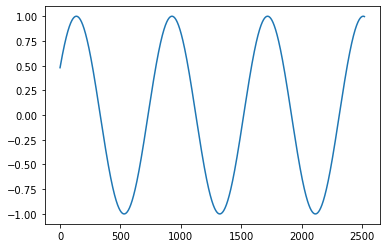

In [47]:
N = 252*10
np.random.seed(0)

rand = np.random.random(N)

idx = np.linspace(0,10, N)
s = pd.Series(1*np.sin(2 * idx + 0.5))
s.plot()

#### (a) Compute the ADF statistic on this series. What is the p-value?

In [48]:
adf = lambda x: adfuller(x)[0]
p_val = lambda x: adfuller(x)[1]

print('ADF: {}'.format(adf(s)))
print('P-Value: {}'.format(p_val(s)))

ADF: -8056583216626.574
P-Value: 0.0


#### (b) Shift every observation by the same positive value. Compute the cumulative sum of the observations. This is a non-stationary series with memory.

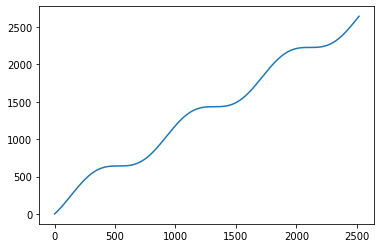

In [60]:
s2 = (s + 1).cumsum()
s2.plot()

#### (i) Compute the ADF statistic on this series. What is the p-value?

In [63]:
print('ADF: {}'.format(adf(s2)))
print('P-Value: {}'.format(p_val(s2)))

ADF: -0.2126412600003026
P-Value: 0.9369979424289693


#### (ii) Apply an expanding window fracdiff, with 𝜏 = 1E − 2. For what minimum d value do you get a p-value below 5%?

,adfStat,pVal,lags,nObs,95% conf
0.000000,2.833609,1.000000,1.000000,2517.000000,-2.862689
0.100000,8.870880,1.000000,1.000000,761.000000,-2.865345
0.200000,-7.366367,0.000000,1.000000,963.000000,-2.864546
0.300000,-22.676076,0.000000,1.000000,1357.000000,-2.863672
0.400000,-22.597921,0.000000,1.000000,1821.000000,-2.863128
0.500000,-37.815563,0.000000,1.000000,2188.000000,-2.862862
0.600000,-43.887336,0.000000,1.000000,2385.000000,-2.862753
0.700000,-63.225457,0.000000,1.000000,2466.000000,-2.862713
0.800000,-73.715117,0.000000,1.000000,2497.000000,-2.862698
0.900000,-48.778288,0.000000,1.000000,2510.000000,-2.862692


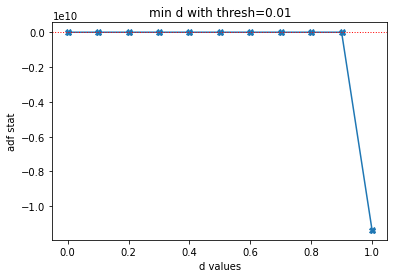

In [68]:
cols = ['adfStat','pVal','lags','nObs','95% conf']#,'corr']
out = pd.DataFrame(columns=cols)
for d in np.linspace(0,1,11):
    try:
        df0 = fracDiff(pd.DataFrame(s2),d)
        df0 = adfuller(df0 ,maxlag=1,regression='c',autolag=None)
        out.loc[d]=list(df0[:4])+[df0[4]['5%']]
    except: 
        break

f,ax=mpl.subplots()
out['adfStat'].plot(ax=ax, marker='X')
ax.axhline(out['95% conf'].mean(),lw=1,color='r',ls='dotted')
ax.set_title('min d with thresh=0.01')
ax.set_xlabel('d values')
ax.set_ylabel('adf stat');
display(out)

#### (iii) Apply FFD, with 𝜏 = 1E − 5. For what minimum d value do you get a p-value below 5%?

,adfStat,pVal,lags,nObs,95% conf
1.000000,-11361055808.381813,0.000000,1.000000,2517.000000,-2.862689
0.900000,-56.157846,0.000000,1.000000,2394.000000,-2.862748
0.800000,-48.464706,0.000000,1.000000,2291.000000,-2.862802
0.700000,-47.470869,0.000000,1.000000,2147.000000,-2.862887
0.600000,-38.630234,0.000000,1.000000,1929.000000,-2.863039
0.500000,-28.339911,0.000000,1.000000,1592.000000,-2.863357
0.400000,-31.359483,0.000000,1.000000,1061.000000,-2.864268
0.300000,-731.465905,0.000000,1.000000,244.000000,-2.873459


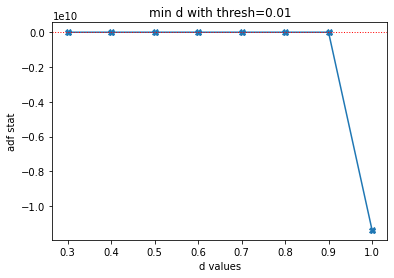

In [73]:
cols = ['adfStat','pVal','lags','nObs','95% conf']#,'corr']
out = pd.DataFrame(columns=cols)
for d in np.linspace(0,1,11)[::-1]:
    try:
        df0 = fracDiff_FFD(pd.DataFrame(s2),d, thres=1e-5)
        df0 = adfuller(df0 ,maxlag=1,regression='c',autolag=None)
        out.loc[d]=list(df0[:4])+[df0[4]['5%']]
    except: 
        break

f,ax=mpl.subplots()
out['adfStat'].plot(ax=ax, marker='X')
ax.axhline(out['95% conf'].mean(),lw=1,color='r',ls='dotted')
ax.set_title('min d with thresh=0.01')
ax.set_xlabel('d values')
ax.set_ylabel('adf stat');
display(out)

### 3. Take the series from exercise 2.b:
#### (a) Fit the series to a sine function. What is the R-squared?

In [74]:
## fitting function taken from stackoverflow
##   https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy#16716964
import numpy, scipy.optimize

def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * numpy.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}


In [77]:
res = fit_sin(s2.index.values, s2.values.ravel())
res

{'amp': -2126.28497327643,
 'omega': 0.0004797999160483457,
 'phase': 2.6281709498529127,
 'offset': 1186.5758371354623,
 'freq': 7.636252833417061e-05,
 'period': 13095.42810871705,
 'fitfunc': <function __main__.fit_sin.<locals>.<lambda>(t)>,
 'maxcov': 20695.213995596652,
 'rawres': (array([1.01493055e+03, 2.49332750e-03, 0.00000000e+00, 1.36801775e+03]),
  array([-2.12628497e+03,  4.79799916e-04,  2.62817095e+00,  1.18657584e+03]),
  array([[ 2.06952140e+04,  4.98650071e-03, -7.28184777e+00,
           3.99478365e+03],
         [ 4.98650071e-03,  1.20345336e-09, -1.74718033e-06,
           9.43036453e-04],
         [-7.28184777e+00, -1.74718033e-06,  2.76112066e-03,
          -1.81976093e+00],
         [ 3.99478365e+03,  9.43036453e-04, -1.81976093e+00,
           1.64645583e+03]]))}

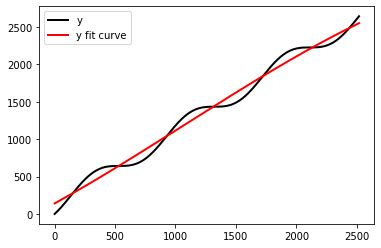

In [79]:
xx = s2.index.values
yy = s2.values.ravel()

mpl.plot(xx, yy, "-k", label="y", linewidth=2)
#plt.plot(tt, yynoise, "ok", label="y with noise")
mpl.plot(xx, res["fitfunc"](xx), "r-", label="y fit curve", linewidth=2)
mpl.legend(loc="best")
mpl.show()



In [80]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(yy, res["fitfunc"](xx))
r_value**2

0.9859147406461108

#### (b) Apply FFD(d = 1). Fit the series to a sine function. What is the R-squared?

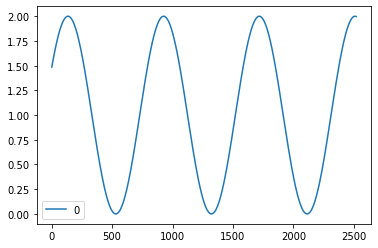

In [90]:
s3 = fracDiff_FFD(s2.to_frame(), d=1)
s3.plot()

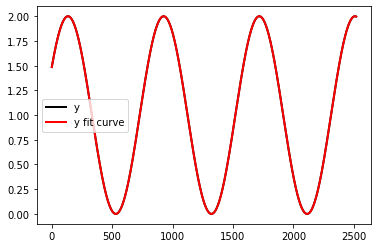

0.9859147406461108


In [91]:
res = fit_sin(s3.index.values, s3.values.ravel())
xx = s3.index.values
yy = s3.values.ravel()

mpl.plot(xx, yy, "-k", label="y", linewidth=2)
#plt.plot(tt, yynoise, "ok", label="y with noise")
mpl.plot(xx, res["fitfunc"](xx), "r-", label="y fit curve", linewidth=2)
mpl.legend(loc="best")
mpl.show()
print(r_value**2)

#### (c) What value of d maximizes the R-squared of a sinusoidal fit on FFD(d). Why?

### 4. Take the dollar bar series on E-mini S&P 500 futures.
  - Using the code in Snippet 5.3, for some "d ∈ [0, 2]", compute fracDiff_FFD(fracDiff_FFD(series,d),-d). What do you get? Why? 
This never finishes!

In [8]:
dbars = generate_dollarbars(df[['dt', 'price', 'quantity']].head(100000).values, 10000)
# d = 0.5
# a = fracDiff_FFD(bars2[['close']], d)
# res = fracDiff_FFD(a, -d)

### 5. Take the dollar bar series on E-mini S&P 500 futures.
#### (a) Form a new series as a cumulative sum of log-prices.
#### (b) Apply FFD, with 𝜏 = 1E − 5. Determine for what minimum d ∈ [0, 2] the new series is stationary.


In [14]:
y = pd.DataFrame(np.log(dbars.close).cumsum())

def get_optimal_ffd(series, ds, t=1e-5):
    
    cols = ['adfStat','pVal','lags','nObs','95% conf']#,'corr']
    out = pd.DataFrame(columns=cols)
    
    for d in ds:
        try:
            #dfx = fracDiff(x.to_frame(),d,thres=1e-5)
            dfx = fracDiff_FFD(series, d, thres=t)
            dfx = adfuller(dfx, maxlag=1,regression='c',autolag=None)
            out.loc[d]=list(dfx[:4])+[dfx[4]['5%']]
        except Exception as e:
            print(dfx)
            print(f'{d} error: {e}')
            break
    return out

#============================================
ds = [0.25,0.5,1,1.5,1.8,1.9,1.999,2]
thres = 1e-5
out = get_optimal_ffd(y, ds, thres)

,adfStat,pVal,lags,nObs,95% conf
0.250000,7.337879,1.000000,1.000000,20604.000000,-2.861680
0.500000,17.417946,1.000000,1.000000,22481.000000,-2.861669
1.000000,-1.663385,0.450069,1.000000,23406.000000,-2.861663
1.500000,3.546949,1.000000,1.000000,23336.000000,-2.861664
1.800000,1.655118,0.998014,1.000000,23366.000000,-2.861664
1.900000,1.127249,0.995443,1.000000,23377.000000,-2.861664
1.999000,0.239799,0.974408,1.000000,23401.000000,-2.861664
2.000000,-105.547025,0.000000,1.000000,23405.000000,-2.861663


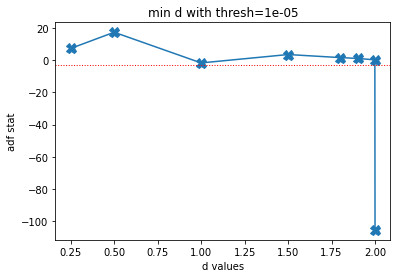

In [12]:
f,ax=mpl.subplots()
out['adfStat'].plot(ax=ax, marker="X", markersize=10)
ax.axhline(out['95% conf'].mean(),lw=1,color='r',ls='dotted')
ax.set_title(f'min d with thresh={thres}')
ax.set_xlabel('d values')
ax.set_ylabel('adf stat');
display(out)

#### (c) Compute the correlation of the fracdiffseries to the original (untransformed)series.


In [30]:
fy  = fracDiff_FFD(y, 2, thres=1e-5)

c = y.rename(columns={'close':'original'}).join(fy, how='inner')
c.corr()

,original,close
original,1.000000,-0.007144
close,-0.007144,1.000000


#### (d) Apply an Engel-Granger cointegration test on the original and fracdiffseries. Are they cointegrated? Why?

In [32]:
coint(c.original, c.close, return_results=True)

(-1.788438154440511,
 0.6353209385922047,
 array([-3.89659954, -3.33621901, -3.04451178]))

We can not reject the null hyphothesis, therefor there is co-integration

#### (e) Apply a Jarque-Bera normality test on the fracdiff series.

In [37]:
jarque_bera(fy)

(array([99846.82958946]),
 array([0.]),
 array([0.00638334]),
 array([13.11811328]))

We can reject the test hyphothesis that the data is normally distributed

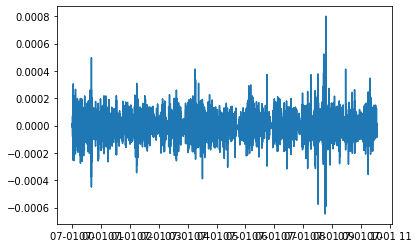

In [38]:
mpl.plot(fy)

### 6. Take the fracdiff series from exercise 5.
- (a) Apply a CUSUM filter (Chapter 2), where h is twice the standard deviation
of the series.
- (b) Use the filtered timestamps to sample a features’ matrix. Use as one of the
features the fracdiff value.
- (c) Form labels using the triple-barrier method, with symmetric horizontal barriers of twice the daily standard deviation, and a vertical barrier of 5 days.
- (d) Fit a bagging classifier of decision trees where:
  - (i) The observed features are bootstrapped using the sequential method from Chapter 4.
  - (ii) On each bootstrapped sample, sample weights are determined using the techniques from Chapter 4.